In [115]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [116]:
dataset = pd.read_csv('../../dataset/final_dataset.csv')
dataset.head(10)

,Unnamed: 0,Time,Day ahead forecast,Hour ahead forecast,Current demand,Time.1,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Natural gas,Large hydro,Batteries,Imports,Other
0,0,00:00,23437.0,22290.0,22216.0,00:00,0.0,2810.0,993.0,380.0,225.0,200.0,11.0,2273.0,7326.0,1924.0,6.0,6254.0,0.0
1,1,00:05,22363.0,22089.0,22106.0,00:05,0.0,2862.0,993.0,381.0,226.0,201.0,11.0,2273.0,7200.0,1866.0,65.0,6266.0,0.0
2,2,00:10,22363.0,22089.0,22130.0,00:10,0.0,2916.0,993.0,380.0,226.0,202.0,11.0,2272.0,7057.0,1849.0,64.0,6319.0,0.0
3,3,00:15,22363.0,22089.0,22040.0,00:15,0.0,2920.0,993.0,378.0,223.0,203.0,11.0,2272.0,7007.0,1827.0,25.0,6354.0,0.0
4,4,00:20,22363.0,21867.0,21963.0,00:20,0.0,2902.0,993.0,379.0,223.0,203.0,11.0,2273.0,6970.0,1840.0,32.0,6360.0,0.0
5,5,00:25,22363.0,21867.0,21867.0,00:25,0.0,2874.0,992.0,379.0,223.0,205.0,11.0,2271.0,6926.0,1840.0,25.0,6302.0,0.0
6,6,00:30,22363.0,21867.0,21792.0,00:30,0.0,2845.0,993.0,379.0,223.0,203.0,11.0,2273.0,6919.0,1845.0,38.0,6270.0,0.0
7,7,00:35,22363.0,21626.0,21731.0,00:35,0.0,2807.0,993.0,378.0,224.0,203.0,11.0,2273.0,6885.0,1843.0,40.0,6263.0,0.0
8,8,00:40,22363.0,21626.0,21666.0,00:40,0.0,2763.0,992.0,377.0,224.0,198.0,11.0,2274.0,6789.0,1831.0,34.0,6338.0,0.0
9,9,00:45,22363.0,21626.0,21624.0,00:45,0.0,2735.0,992.0,377.0,218.0,197.0,11.0,2273.0,6761.0,1902.0,33.0,6352.0,0.0


In [117]:
training_df = dataset.iloc[:,[1,4,12,13,14,16,17,18]]
training_df.head(10)

,Time,Current demand,Coal,Nuclear,Natural gas,Batteries,Imports,Other
0,00:00,22216.0,11.0,2273.0,7326.0,6.0,6254.0,0.0
1,00:05,22106.0,11.0,2273.0,7200.0,65.0,6266.0,0.0
2,00:10,22130.0,11.0,2272.0,7057.0,64.0,6319.0,0.0
3,00:15,22040.0,11.0,2272.0,7007.0,25.0,6354.0,0.0
4,00:20,21963.0,11.0,2273.0,6970.0,32.0,6360.0,0.0
5,00:25,21867.0,11.0,2271.0,6926.0,25.0,6302.0,0.0
6,00:30,21792.0,11.0,2273.0,6919.0,38.0,6270.0,0.0
7,00:35,21731.0,11.0,2273.0,6885.0,40.0,6263.0,0.0
8,00:40,21666.0,11.0,2274.0,6789.0,34.0,6338.0,0.0
9,00:45,21624.0,11.0,2273.0,6761.0,33.0,6352.0,0.0


In [118]:
training_df = training_df.assign(Total_t=training_df[['Coal','Nuclear','Natural gas','Batteries','Imports','Other']].sum(axis=1))
training_df.head(10)

,Time,Current demand,Coal,Nuclear,Natural gas,Batteries,Imports,Other,Total_t
0,00:00,22216.0,11.0,2273.0,7326.0,6.0,6254.0,0.0,15870.0
1,00:05,22106.0,11.0,2273.0,7200.0,65.0,6266.0,0.0,15815.0
2,00:10,22130.0,11.0,2272.0,7057.0,64.0,6319.0,0.0,15723.0
3,00:15,22040.0,11.0,2272.0,7007.0,25.0,6354.0,0.0,15669.0
4,00:20,21963.0,11.0,2273.0,6970.0,32.0,6360.0,0.0,15646.0
5,00:25,21867.0,11.0,2271.0,6926.0,25.0,6302.0,0.0,15535.0
6,00:30,21792.0,11.0,2273.0,6919.0,38.0,6270.0,0.0,15511.0
7,00:35,21731.0,11.0,2273.0,6885.0,40.0,6263.0,0.0,15472.0
8,00:40,21666.0,11.0,2274.0,6789.0,34.0,6338.0,0.0,15446.0
9,00:45,21624.0,11.0,2273.0,6761.0,33.0,6352.0,0.0,15430.0


In [119]:
complete_set = training_df[['Total_t']].values
complete_set = complete_set.astype('float32') # We had some issues further down
complete_set

array([[15870.],
       [15815.],
       [15723.],
       ...,
       [    0.],
       [    0.],
       [    0.]], dtype=float32)

In [120]:
# We normalize our set (0, 1)
scaler = MinMaxScaler(feature_range = (0, 1))
complete_set = scaler.fit_transform(complete_set)
complete_set


array([[0.9315028 ],
       [0.93132746],
       [0.931034  ],
       ...,
       [0.88089293],
       [0.88089293],
       [0.88089293]], dtype=float32)

In [121]:
slice_point = 30*288
random_interval = random.randint(5,10)
train = complete_set[:slice_point]
validation = complete_set[random_interval*slice_point:random_interval*slice_point+(5*288)]
print('Training set shape --> {}, \tValidation set shape --> {}'.format(train.shape, validation.shape))

Training set shape --> (8640, 1), 	Validation set shape --> (1440, 1)


Network data preprocessing

In [122]:
train = pd.DataFrame(train, columns=['Total (t)'])
validation = pd.DataFrame(validation, columns=['Total (t)'])
train

,Total (t)
0,0.931503
1,0.931327
2,0.931034
3,0.930862
4,0.930789
...,...
8635,0.937297
8636,0.938423
8637,0.938225
8638,0.937779


In [123]:
train = train.to_numpy()
validation = validation.to_numpy()
look_back = 1

def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

train_X, train_Y = create_dataset(train, look_back)
validation_X, validation_Y = create_dataset(validation, look_back)

print('train_X shape --> {}\ttrain_Y shape --> {}\tvalidation_X shape --> {}\tvalidation_Y shape --> {}'.format(train_X.shape, train_Y.shape, validation_X.shape, validation_Y.shape))



train_X shape --> (8638, 1)	train_Y shape --> (8638,)	validation_X shape --> (1438, 1)	validation_Y shape --> (1438,)


In [124]:
# reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
validation_X = np.reshape(validation_X, (validation_X.shape[0], 1, validation_X.shape[1]))

train_X.shape

(8638, 1, 1)

NETWORK ARCHITECTURE


In [125]:

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['Accuracy'])
model.fit(train_X, train_Y, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
8638/8638 - 8s - loss: 0.0020 - Accuracy: 0.0000e+00 - 8s/epoch - 922us/step
Epoch 2/10
8638/8638 - 7s - loss: 1.9602e-05 - Accuracy: 0.0000e+00 - 7s/epoch - 820us/step
Epoch 3/10
8638/8638 - 7s - loss: 4.8325e-06 - Accuracy: 0.0000e+00 - 7s/epoch - 820us/step
Epoch 4/10
8638/8638 - 7s - loss: 4.6316e-06 - Accuracy: 0.0000e+00 - 7s/epoch - 836us/step
Epoch 5/10
8638/8638 - 7s - loss: 4.4983e-06 - Accuracy: 0.0000e+00 - 7s/epoch - 815us/step
Epoch 6/10
8638/8638 - 7s - loss: 4.0097e-06 - Accuracy: 0.0000e+00 - 7s/epoch - 832us/step
Epoch 7/10
8638/8638 - 7s - loss: 4.1083e-06 - Accuracy: 0.0000e+00 - 7s/epoch - 837us/step
Epoch 8/10
8638/8638 - 7s - loss: 4.0267e-06 - Accuracy: 0.0000e+00 - 7s/epoch - 832us/step
Epoch 9/10
8638/8638 - 7s - loss: 3.9163e-06 - Accuracy: 0.0000e+00 - 7s/epoch - 830us/step
Epoch 10/10
8638/8638 - 7s - loss: 3.6703e-06 - Accuracy: 0.0000e+00 - 7s/epoch - 835us/step


In [126]:
trainPredict = model.predict(train_X)
trainPredict = scaler.inverse_transform(trainPredict)
train_Y = scaler.inverse_transform([train_Y])
train_Y.shape

(1, 8638)

In [127]:
validationPredict = model.predict(validation_X)
validationPredict = scaler.inverse_transform(validationPredict)
validation_Y = scaler.inverse_transform([validation_Y])
validation_Y.shape

(1, 1438)

In [128]:
trainScore = np.sqrt(mean_squared_error(train_Y[0], trainPredict[:,0]))
trainScore

252.10118678376764

In [129]:
validationScore = np.sqrt(mean_squared_error(validation_Y[0], validationPredict[:,0]))
validationScore

9176.024508063594

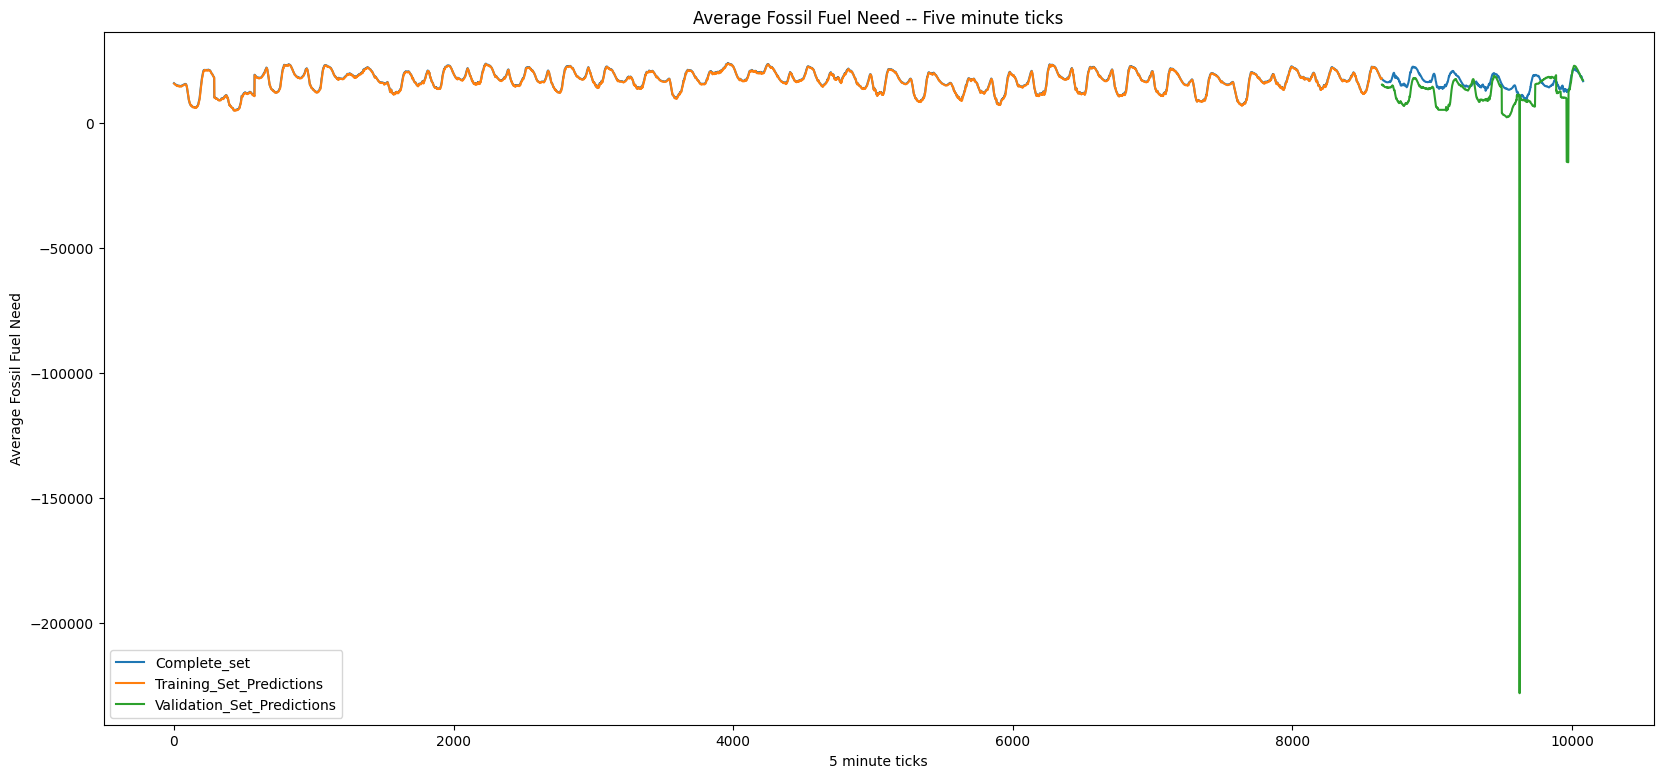

In [130]:
# shift train predictions for plotting
complete_set = complete_set[:slice_point+(5*288)]
trainPredictPlot = np.empty_like(complete_set)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back: len(trainPredict) + look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(complete_set)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1: len(complete_set) - 1, :] = validationPredict
# # plot baseline and predictions
plt.figure(figsize=(20,9))
plt.title('Average Fossil Fuel Need -- Five minute ticks')
plt.xlabel('5 minute ticks')
plt.ylabel('Average Fossil Fuel Need')
plt.plot(scaler.inverse_transform(complete_set))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Complete_set', 'Training_Set_Predictions', 'Validation_Set_Predictions'])
plt.show()